In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import warnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold

/kaggle/input/car-price-dataset/car_price_dataset.csv


In [2]:
# Load the data
data = pd.read_csv("/kaggle/input/car-price-dataset/car_price_dataset.csv")
data.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


# Exploring the data
# Fields and data types 🗒️:
- **Brand**: Specifies the brand of the car (e.g., Toyota, BMW, Ford).
- **Model**: Specifies the model of the car (e.g., Corolla, Focus, X5).
- **Year**: The production year of the car. Newer years typically indicate higher prices.
- **Engine_Size**: Specifies the engine size in liters (L). Larger engines generally correlate with higher prices.
- **Fuel_Type**: indicates the type of fuel used by the car:
    * **Petrol**: Cars running on gasoline.
    * **Diesel**: Cars running on diesel fuel.
    * **Hybrid**: Cars that use both fuel and electricity.
    * **Electric**: Fully electric cars.
- **Transmission**: The type of transmission in the car:
    * **Manual**: Manual transmission.
    * **Automatic**: Automatic transmission.
    * **Semi-Automatic**: Semi-automatic transmission.
- **Mileage**: The total distance the car has traveled, measured in kilometers. Lower mileage generally indicates a higher price.
- **Doors**: The number of doors in the car. Commonly 2, 3, 4, or 5 doors.
- **Owner_Count**: The number of previous owners of the car. Fewer owners generally indicate a higher price.
- **Price**:The estimated selling price of the car. It is calculated based on several factors such as production year, engine size, mileage, fuel type, and transmission.

# Understanding Data

In [3]:
data.shape

(10000, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


# Now i going to checking the number of unique values in each column

In [5]:
dict = {}
for i in list(data.columns):
    dict[i] = data[i].value_counts().shape[0]
pd.DataFrame(dict, index=['unique count']).transpose()

,unique count
Brand,10
Model,30
Year,24
Engine_Size,41
Fuel_Type,4
Transmission,3
Mileage,9854
Doors,4
Owner_Count,5
Price,6661


# Summary Statistics

In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,10000.0,2011.54370,6.897699,2000.0,2006.00,2012.0,2017.0,2023.0
Engine_Size,10000.0,3.00056,1.149324,1.0,2.00,3.0,4.0,5.0
Mileage,10000.0,149239.11180,86322.348957,25.0,74649.25,149587.0,223577.5,299947.0
Doors,10000.0,3.49710,1.110097,2.0,3.00,3.0,4.0,5.0
Owner_Count,10000.0,2.99110,1.422682,1.0,2.00,3.0,4.0,5.0
Price,10000.0,8852.96440,3112.596810,2000.0,6646.00,8858.5,11086.5,18301.0


# Missing values

In [7]:
data.isnull().sum()

Brand           0
Model           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64

# EDA (Exploratory Data Analysis)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/pyth

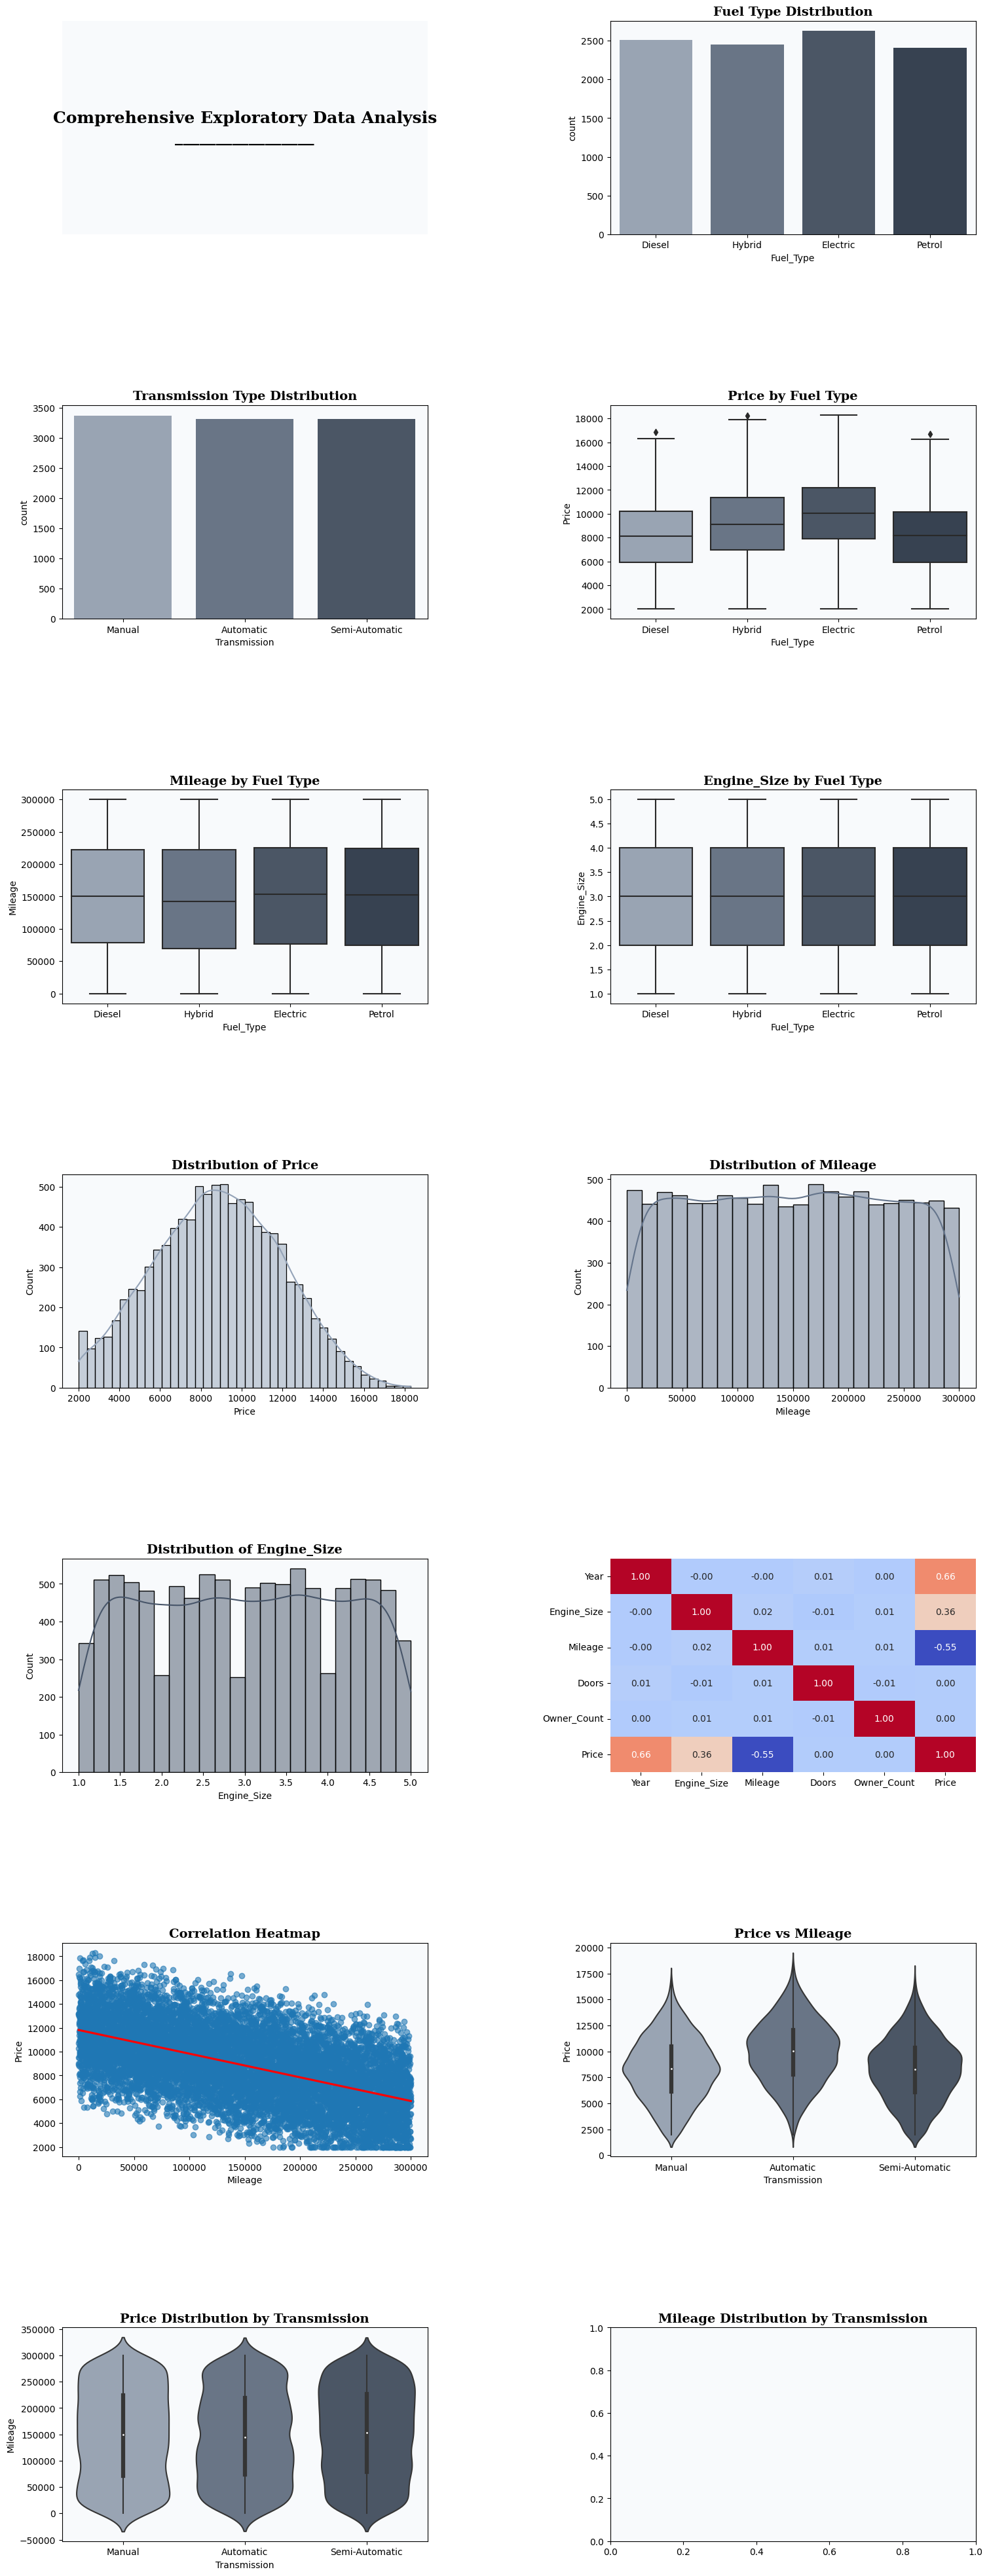

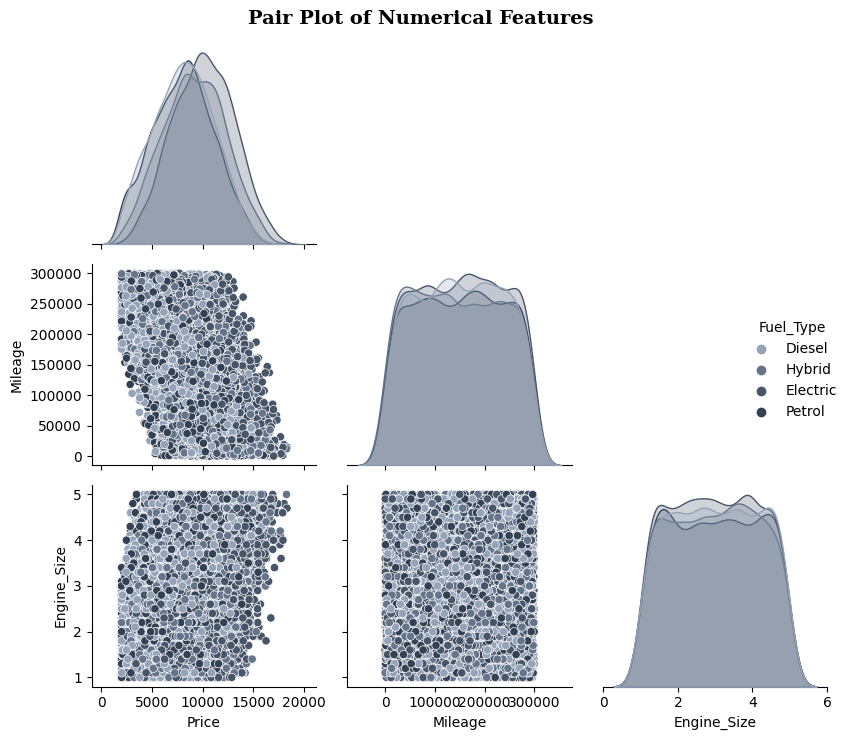

In [8]:
# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# General plot settings
background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]

# Adjust figure size and layout
fig = plt.figure(figsize=(18, 50))
gs = fig.add_gridspec(7, 2)
gs.update(wspace=0.5, hspace=0.8)

# Create axes for subplots
axes = [fig.add_subplot(gs[i, j]) for i in range(7) for j in range(2)]
for ax in axes:
    ax.set_facecolor(background_color)

# Title for the overall analysis
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Comprehensive Exploratory Data Analysis\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

# Count plot for 'Fuel_Type'
sns.countplot(ax=axes[1], data=data, x='Fuel_Type', palette=color_palette)
axes[1].set_title('Fuel Type Distribution', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Count plot for 'Transmission'
sns.countplot(ax=axes[2], data=data, x='Transmission', palette=color_palette)
axes[2].set_title('Transmission Type Distribution', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Boxplots for numerical vs. categorical relationships
num_features = ['Price', 'Mileage', 'Engine_Size']
for i, feature in enumerate(num_features):
    sns.boxplot(ax=axes[i + 3], data=data, x='Fuel_Type', y=feature, palette=color_palette)
    axes[i + 3].set_title(f'{feature} by Fuel Type', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Distribution plots for numerical features
numerical_features = ['Price', 'Mileage', 'Engine_Size']
for i, feature in enumerate(numerical_features):
    sns.histplot(ax=axes[i + 6], data=data, x=feature, kde=True, color=color_palette[i % len(color_palette)])
    axes[i + 6].set_title(f'Distribution of {feature}', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Pair plot for numerical features
sns.pairplot(data=data, vars=numerical_features, hue='Fuel_Type', palette=color_palette, corner=True)
plt.subplots_adjust(top=0.95)
plt.suptitle('Pair Plot of Numerical Features', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Correlation heatmap for numeric data
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, ax=axes[9], annot=True, fmt='.2f', cmap='coolwarm', cbar=False)
axes[10].set_title('Correlation Heatmap', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Scatter plot with regression line
sns.regplot(ax=axes[10], data=data, x='Mileage', y='Price', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axes[11].set_title('Price vs Mileage', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Violin plots for numerical features by Transmission
violin_features = ['Price', 'Mileage']
for i, feature in enumerate(violin_features):
    sns.violinplot(ax=axes[i + 11], data=data, x='Transmission', y=feature, palette=color_palette)
    axes[i + 12].set_title(f'{feature} Distribution by Transmission', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Show the plots
plt.tight_layout()
plt.show()

In [9]:
# Encode categorical variables
encoded_data = data.copy()
label_encoders = {}

for col in encoded_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
    label_encoders[col] = le

# Split data into training and testing sets
X = encoded_data.drop('Price', axis=1)
y = encoded_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a function to evaluate models

In [10]:
# Fits the model, makes predictions, and evaluates performance.
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [ ]:
# Gradient Boosting
gbm_model = GradientBoostingClassifier(random_state=42)
evaluate_model(gbm_model, X_train, X_test, y_train, y_test, "Gradient Boosting")

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
evaluate_model(lgb_model, X_train, X_test, y_train, y_test, "LightGBM")

# Neural Networks
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42)
evaluate_model(mlp_model, X_train, X_test, y_train, y_test, "Neural Network")

# Compare models using cross-validation
models = {
    "Gradient Boosting": gbm_model,
    "LightGBM": lgb_model,
    "Neural Network": mlp_model
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")